In [5]:
%pylab inline

import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Heatmaps for node2vec and propagation method

In [1]:
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial import distance
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph

In [ ]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 10000)

In [ ]:
'''
graph = '../data/graph/lesmiserables/lesmiserables_edgelist.txt'
G = read_graph(weighted=False, 
               graph=graph,
               directed=False)
'''

In [ ]:
#G = nx.barabasi_albert_graph(100, m=2)
G = nx.watts_strogatz_graph(200, 10, 0.1, seed=42)
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

In [ ]:
p_val = [0.05, 0.25, 0.5, 1, 5, 25, 50]
q_val = [0.05, 0.25, 0.5, 1, 5, 25, 50]

dimensions=[10]
walk_length=[80]
num_walks=[10]
window_size=[10]
iiter=[1]

In [ ]:
args_list = []

nr_experiments = 10

for d in dimensions:
    for wk in walk_length:
        for n in num_walks:
            for wi in window_size:
                for ii in iiter:
                    for p in p_val:
                        for q in q_val:
                            for seed in range(nr_experiments):
                                args = [d, wk, n, wi, ii, p, q, seed]
                                args_list.append(args)

In [ ]:
def run_experiment(*args):
    d, wk, n, wi, ii, p, q, seed = args
    G_emb = n2i_nx_graph(nx_graph=G, 
             dimensions=d, walk_length=wk,
             num_walks=n, window_size=wi,
             iiter=ii, p=p, q=q,
             beta=5,
             alpha_value=0.5,
             beta_value=0.5,
             prior='beta',
             seed=seed+int(1000*(q+p)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 50)
    return args + (si/so,)

In [ ]:
result = list(map(lambda x: run_experiment(*x), args_list))

In [ ]:
df = pd.DataFrame(result, columns=['d', 'wk', 'n', 'wi', 'ii', 'p', 'q', 'seed', 'hom'])
df.head()

In [ ]:
df2 = df.groupby(['p', 'q'])['hom'].mean().unstack()

In [ ]:
sns.heatmap(df2)
plt.title('Homophily (mean of 10 realizations)')

In [7]:
df = pd.read_csv('node2vec-heatmap.csv')
df2 = df.groupby(['p', 'q'])['hom'].mean().unstack()

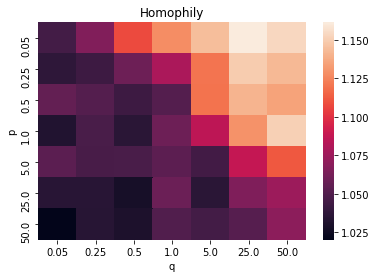

In [11]:
plt.title('Homophily')
sns.heatmap(df2)
plt.savefig('Plots/heatmap_n2v.pdf')

In [9]:
df.head()

,Unnamed: 0,d,wk,n,wi,ii,p,q,seed,hom
0,0,10,80,10,10,1,0.05,0.05,0,1.034355
1,1,10,80,10,10,1,0.05,0.05,1,1.047446
2,2,10,80,10,10,1,0.05,0.05,2,0.994022
3,3,10,80,10,10,1,0.05,0.05,3,1.068945
4,4,10,80,10,10,1,0.05,0.05,4,0.993384


In [10]:
! cd Plots ; ls

heatmap_nmf.pdf  heatmap_prop.pdf
